In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install pandarallel
print("INSTALLATIONS COMPLETE.")

INSTALLATIONS COMPLETE.


## Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from tqdm.notebook import tqdm
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate, KFold, cross_val_score, StratifiedKFold , cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
import optuna
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    

print('Imports done.')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip
Imports done.


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [3]:
train_df = pd.read_csv('/kaggle/input/bigdata2023classification/train.csv')
test_df = pd.read_csv('/kaggle/input/bigdata2023classification/test_without_labels.csv')

train_df['Label_id'] = train_df['Label'].factorize()[0] # create specific ID for each label. Helps later on with wordclouds.

train_df.head()

,Id,Title,Content,Label,Label_id
0,227464,"Netflix is coming to cable boxes, and Amazon i...",if you subscribe to one of three rinky-dink (...,Entertainment,0
1,244074,"Pharrell, Iranian President React to Tehran 'H...","pharrell, iranian president react to tehran '...",Entertainment,0
2,60707,Wildlife service seeks comments,the u.s. fish and wildlife service has reopen...,Technology,1
3,27883,Facebook teams up with Storyful to launch 'FB ...,the very nature of social media means it is o...,Technology,1
4,169596,Caesars plans US$880 mln New York casino,caesars plans us$880 mln new york casino jul ...,Business,2


# Question 1.1

## Data Preprocessing

In [ ]:
# Visualize our data (specifically the Label column)
# Data Distribution

train_df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Countplot for column Label, there seem to be more entertainment articles.
sns.countplot(x='Label',data=train_df)

In [ ]:
# Check which ID corresponds to which label
label = train_df[['Label', 'Label_id']].drop_duplicates().sort_values('Label_id')
label

In [ ]:
# Checking shapes
print('train_df size: ', train_df.shape)
print('test_df size: ', test_df.shape)
# 159707 full size

Entertainment wordcloud: 


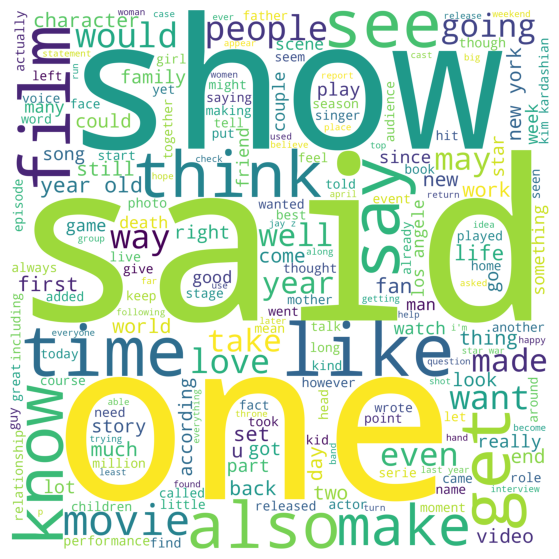

Technology wordcloud: 


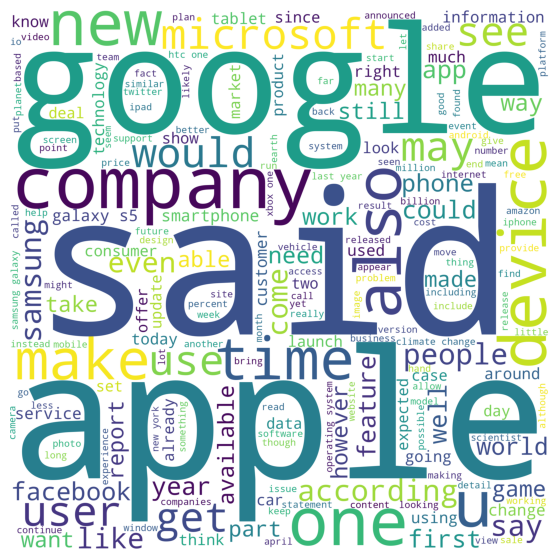

Business wordcloud: 


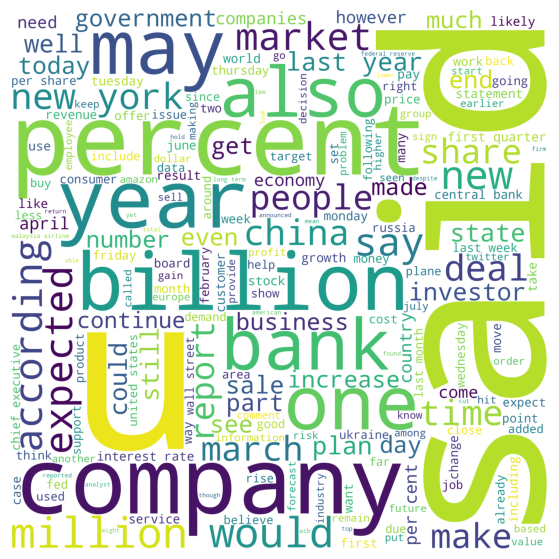

Health wordcloud: 


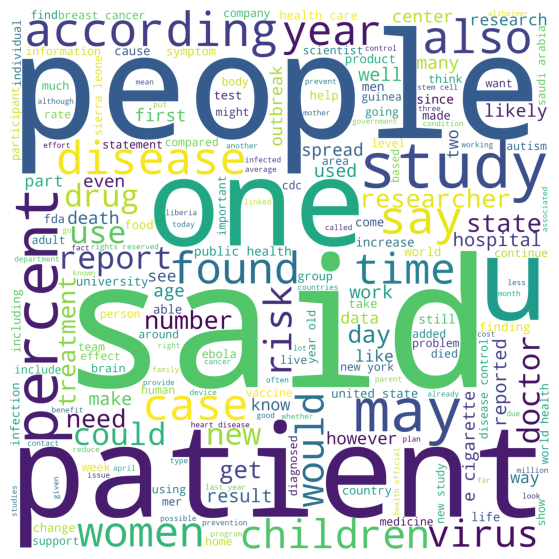

In [4]:
# Word cloud creation
# get stopwords.
stop = set(stopwords.words('english'))

# get each label's articles to create word cloud for each label
entertainment = train_df[train_df['Label_id'] == 0]
entertainment = entertainment['Content']

technology = train_df[train_df['Label_id'] == 1]
technology = technology['Content']

business = train_df[train_df['Label_id'] == 2]
business = business['Content']

health = train_df[train_df['Label_id'] == 3]
health = health['Content']

def wordcloud_draw(dataset, color = 'white'):
    words = ' '.join(dataset)
    cleaned_word = ' '.join([word for word in words.split()
    if (word != 'news' and word != 'text')])
    wordcloud = WordCloud(stopwords = stop,
    background_color = color,
    width = 2500, height = 2500).generate(cleaned_word)
    plt.figure(1, figsize = (10,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
print('Entertainment wordcloud: ')
wordcloud_draw(entertainment)

print('Technology wordcloud: ')
wordcloud_draw(technology)

print('Business wordcloud: ')
wordcloud_draw(business)

print('Health wordcloud: ')
wordcloud_draw(health)

# Question 1.2

In [5]:
# Text preprocessing for Content column
# Lower all text

train_df['Content'] = train_df['Content'].str.lower()
test_df['Content'] = test_df['Content'].str.lower()

# Initialize pandarallel
# I used pandarallel because it applies the functions much faster than a normal pandas apply.
pandarallel.initialize(nb_workers=8,progress_bar=True)

# Remove all special characters
def remove_special_chars(text):
    return ''.join(x if x.isalnum() else ' ' for x in text)

train_df['Content'] = train_df['Content'].parallel_apply(remove_special_chars)
test_df['Content'] = test_df['Content'].parallel_apply(remove_special_chars)

# Remove stop_words
def remove_stopwords(text):
    words = word_tokenize(text)
    return [x for x in words if x not in stop]

train_df['Content'] = train_df['Content'].parallel_apply(remove_stopwords)
test_df['Content'] = test_df['Content'].parallel_apply(remove_stopwords)

# Lemmatization
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])

train_df['Content'] = train_df['Content'].parallel_apply(lemmatize_word)
test_df['Content'] = test_df['Content'].parallel_apply(lemmatize_word)



print('Example of preprocessing train: ')
print(train_df['Content'][0])
print("\n")
print('Example of preprocessing test: ')
print(test_df['Content'][0])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Example of preprocessing train: 
subscribe one three rinky dink comparatively speaking cable company able watch netflix another channel provided already certain type set top box still need subscribe netflix need another filter netflix ready tv roku playstation etc order word netflix become pay cable channel albeit one pay directly unlike hbo generally bundled cable bill stolen via hbo go company rcn grande communication atlantic broadband expect fight time warner comcasts probably signal change netflix user certainly potential open network new subscriber mega corp news amazon launched prime pantry part company plan break ups driver back make complete shut amazon long sold thing like toothpaste toilet paper hell yeah subscribe n save expanded household grocery item deliver 45 pound product 5 99 including cost stuff actually measured cubic inch fill box let know much room left basically grocery shopping like tetri must amazon prime subscriber use service though price recently went privil

## Bag of words 

In [ ]:
# Count vectorizer will represent the BOW model.

X_train = train_df['Content']
X_test = test_df['Content']
y_train = train_df['Label']

count_vectorizer = CountVectorizer()

X_train = count_vectorizer.fit_transform(train_df['Content'])
X_test = count_vectorizer.transform(test_df['Content'])

print('Preprocessing complete.')

## SVM training and evaluation (with BOW)

In [ ]:
# Support Vector Machine (SVM)
# using LinearSVC because it's faster for large datasets , that can be separated linearly 
# and supports One-vs-Rest technique (Great for multi-class labels like our case). 

svm_model = LinearSVC(random_state = 42, max_iter=1000)

# Specify multiple metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted')
    #     'f1_score': make_scorer(f1_score, average='weighted')
}

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(svm_model, X_train, y_train, cv=5)

# Print classification report for each category
print("====================== SVM Classification Report (BOW) ======================")
print("\n")
print(classification_report(y_train, y_pred))

# # Perform 5-fold cross-validation with multiple metrics using cross_validate
# cv_results = cross_validate(svm_model, X_train, y_train , cv=5, scoring=scoring_metrics, return_train_score=False)

# # Print the cross-validation results for each metric
# for metric in scoring_metrics:
#     print(f"SVM {metric.capitalize()}: Mean={np.mean(cv_results[f'test_{metric}']):.5f}, Std={np.std(cv_results[f'test_{metric}']):.5f}")

## Random Forest training and evaluation (BOW)

In [ ]:
# Creating a random forest classifier with 20 Decision trees. Took a small number of trees here because it's really slow with BOW.
rf_model = RandomForestClassifier(n_estimators=20,n_jobs=-1)

# Specify multiple metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted')
}

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(rf_model, X_train, y_train, cv=5)

# Print classification report for each category
print("====================== Random Forest Classification Report (BOW) ======================")
print("\n")
print(classification_report(y_train, y_pred))

# stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Perform 5-fold cross-validation with multiple metrics using cross_validate
# cv_results = cross_validate(rf_model, X_train, y_train , cv=stratified_cv, scoring=scoring_metrics, return_train_score=False, n_jobs=-1)

# # Print the cross-validation results for each metric
# for metric in scoring_metrics:
#     print(f"Random Forest {metric.capitalize()}: Mean={np.mean(cv_results[f'test_{metric}']):.5f}, Std={np.std(cv_results[f'test_{metric}']):.5f}")

## SVD 

In [ ]:
# Perform SVD

svd = TruncatedSVD(n_components=100)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)
print("SVD complete.")

## SVM Training and evaluation (SVD)

In [ ]:
# Support Vector Machine (SVM)
# using LinearSVC because it's faster for large datasets , that can be separated linearly 
# and supports One-vs-Rest technique (Great for multi-class labels like our case). 

svm_model = LinearSVC(random_state = 42, max_iter=1000)
# svm_model.fit(X_train,y_train)
# print('training done.')
# y_pred_test = svm_model.predict(X_test)
# print('X_test done.')
# y_pred_valid = svm_model.predict(X_valid)

# Specify multiple metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted')
}

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(svm_model, X_train_reduced, y_train, cv=5)

# Print classification report for each category
print("====================== SVM Classification Report (SVD) ======================")
print("\n")
print(classification_report(y_train, y_pred))

# # Perform 5-fold cross-validation with multiple metrics using cross_validate
# cv_results = cross_validate(svm_model, X_train_reduced, y_train , cv=5, scoring=scoring_metrics, return_train_score=False)

# # Print the cross-validation results for each metric
# for metric in scoring_metrics:
#     print(f"SVM {metric.capitalize()}: Mean={np.mean(cv_results[f'test_{metric}']):.5f}, Std={np.std(cv_results[f'test_{metric}']):.5f}")

## Random Forest training and evaluation (SVD)

In [ ]:
# Creating a random forest classifier with 100 Decision trees (SVD cross validation is faster than BOW for Random Forest).
rf_model = RandomForestClassifier(n_estimators=100,n_jobs=-1)

# Specify multiple metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted')
#     'f1_score': make_scorer(f1_score, average='weighted')
}

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(rf_model, X_train_reduced, y_train, cv=5)

# Print classification report for each category
print("====================== Random Forest Classification Report (SVD) ======================")
print("\n")
print(classification_report(y_train, y_pred))

# stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Perform 5-fold cross-validation with multiple metrics using cross_validate
# cv_results = cross_validate(rf_model, X_train_reduced, y_train , cv=stratified_cv, scoring=scoring_metrics, return_train_score=False, n_jobs=-1)

# # Print the cross-validation results for each metric
# for metric in scoring_metrics:
#     print(f"Random Forest {metric.capitalize()}: Mean={np.mean(cv_results[f'test_{metric}']):.5f}, Std={np.std(cv_results[f'test_{metric}']):.5f}")

## Beat the benchmark algorithm

In [6]:
# Title added as feature with content (combined), increases accuracy a little bit (0.3% increase).
train_df['Title'] = train_df['Title'].str.lower()
test_df['Title'] = test_df['Title'].str.lower()

pandarallel.initialize(nb_workers=8,progress_bar=True)

train_df['Title'] = train_df['Title'].parallel_apply(remove_special_chars)
test_df['Title'] = test_df['Title'].parallel_apply(remove_special_chars)

train_df['Title'] = train_df['Title'].parallel_apply(remove_stopwords)
test_df['Title'] = test_df['Title'].parallel_apply(remove_stopwords)

train_df['Title'] = train_df['Title'].parallel_apply(lemmatize_word)
test_df['Title'] = test_df['Title'].parallel_apply(lemmatize_word)

train_df['Combined'] = train_df['Title'] + ' ' + train_df['Content']
test_df['Combined'] = test_df['Title'] + ' ' + test_df['Content']

print('Example of preprocessing train: ')
print(train_df['Combined'][0])
print("\n")
print('Example of preprocessing test: ')
print(test_df['Combined'][0])

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Example of preprocessing train: 
netflix coming cable box amazon grocery overlord subscribe one three rinky dink comparatively speaking cable company able watch netflix another channel provided already certain type set top box still need subscribe netflix need another filter netflix ready tv roku playstation etc order word netflix become pay cable channel albeit one pay directly unlike hbo generally bundled cable bill stolen via hbo go company rcn grande communication atlantic broadband expect fight time warner comcasts probably signal change netflix user certainly potential open network new subscriber mega corp news amazon launched prime pantry part company plan break ups driver back make complete shut amazon long sold thing like toothpaste toilet paper hell yeah subscribe n save expanded household grocery item deliver 45 pound product 5 99 including cost stuff actually measured cubic inch fill box let know much room left basically grocery shopping like tetri must amazon prime subscri

In [15]:
X_train = train_df['Combined']
X_test = test_df['Combined']
y_train = train_df['Label']

# Using hashing vectorizer as it's a better form of the classic BOW count vectorizer,
# giving me the best possible results.

hashing_vectorizer = HashingVectorizer()
X_train = hashing_vectorizer.fit_transform(train_df['Combined'])
X_test = hashing_vectorizer.transform(test_df['Combined'])

print('Preprocessing complete.')

Preprocessing complete.


In [ ]:
# Logistic Regression model (BOW) , testing this model but it gave me worse results than LinearSVC with hashing vectorizer.
# Using sag solver since it finishes the fastest out of all solvers (along with saga, 2 minutes)

lr_model = LogisticRegression(tol=1e-4, C=1.0, n_jobs=-1, solver='sag',random_state=42)

# Specify multiple metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted')
} 

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(lr_model, X_train, y_train, cv=5)

# Print classification report for each category
print("====================== Logistic Regression Classification Report ======================")
print("\n")
print(classification_report(y_train, y_pred))

In [ ]:
# XGBoost model
xgb_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=20, max_depth=3, random_state=42)

# Specify multiple metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted')
}

y_label_ids = train_df['Label_id']

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(xgb_model, X_train, y_label_ids, cv=5)

# Print classification report for each category
print("====================== XGBoost Classification Report ======================")
print("\n")
print(classification_report(y_label_ids, y_pred))

In [ ]:
# Support Vector Machine (SVM)
# using LinearSVC because it's faster for large datasets , that can be separated linearly 
# and supports One-vs-Rest technique (Great for multi-class labels like our case). 

# Best model with 97% accuracy

svm_model = LinearSVC(random_state=42, max_iter=1000)

# Perform 5-fold cross-validation and get predictions for each fold
y_pred = cross_val_predict(svm_model, X_train, y_train, cv=5)

# Print classification report for each category
print("====================== SVM Classification Report (Best model) ======================")
print("\n")
print(classification_report(y_train, y_pred))

## Obtain predictions

In [ ]:
svm_model.fit(X_train,y_train)

y_pred_test = svm_model.predict(X_test)

print('Training complete.')

## Output file

In [ ]:
import csv

with open('testSet_categories.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(0,47912):
        writer.writerow([test_df['Id'][i],y_pred_test[i]])  
    
    
print("CSV file writing complete.")

# Question 2

## Brute force k-NN

In [ ]:
X_train_array = train_df['Combined']
X_test_array = test_df['Combined']

# # Tokenize documents into sets of words
# tokenized_articles = [set(word_tokenize(doc)) for doc in X_train_array]

# tokenized_articles = np.array(tokenized_articles)

# tokenized_articles = tokenized_articles.reshape(-1,1)

# # Create a list of all unique words in the corpus
# all_words = list(set(word for doc in tokenized_articles for word in doc))

# # Create a one-hot encoder
# encoder = OneHotEncoder(categories=[all_words], sparse=False)

# tokenized_articles_test = [set(word_tokenize(doc)) for doc in X_test_array]
# tokenized_articles_test = np.array(tokenized_articles_test)
# tokenized_articles_test = tokenized_articles_test.reshape(-1,1)

# one_hot_X_train = encoder.fit_transform(tokenized_articles)
# one_hot_X_test = encoder.transform(tokenized_articles_test)
# print('encoding done.')

tf_idf_vec = TfidfVectorizer()


X_train_array = tf_idf_vec.fit_transform(X_train_array).toarray()
X_test_array = tf_idf_vec.transform(X_test_array).toarray()

nbrs = NearestNeighbors(n_neighbors=15, algorithm='brute', metric='jaccard').fit(X_train_array)

distances, indices = nbrs.kneighbors(X_test_array)

print('k-nn done.')